In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benig

In [2]:
train_data_path = '/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
train_df

,filepaths,label
0,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
1,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
2,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
3,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
4,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
...,...,...
2234,/kaggle/input/skin-cancer-detection/Skin cance...,nevus
2235,/kaggle/input/skin-cancer-detection/Skin cance...,nevus
2236,/kaggle/input/skin-cancer-detection/Skin cance...,nevus
2237,/kaggle/input/skin-cancer-detection/Skin cance...,nevus


In [4]:
test_data_path = "/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

filepaths = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path,fold)
    file_lists = os.listdir(f_path)
    
    
    for file in file_lists:
        filepaths.append(os.path.join(f_path,file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [5]:
test_df

,filepaths,label
0,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
1,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
2,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
3,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
4,/kaggle/input/skin-cancer-detection/Skin cance...,pigmented benign keratosis
...,...,...
113,/kaggle/input/skin-cancer-detection/Skin cance...,nevus
114,/kaggle/input/skin-cancer-detection/Skin cance...,nevus
115,/kaggle/input/skin-cancer-detection/Skin cance...,nevus
116,/kaggle/input/skin-cancer-detection/Skin cance...,nevus


# Splitting the data into valid and test

In [6]:
valid,test = train_test_split(test_df,train_size=0.5,shuffle=True,random_state=42)

# Using IDG (Image Data Generator)

In [7]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2239 validated image filenames belonging to 9 classes.
Found 59 validated image filenames belonging to 9 classes.
Found 59 validated image filenames belonging to 9 classes.


# Show sample from train data

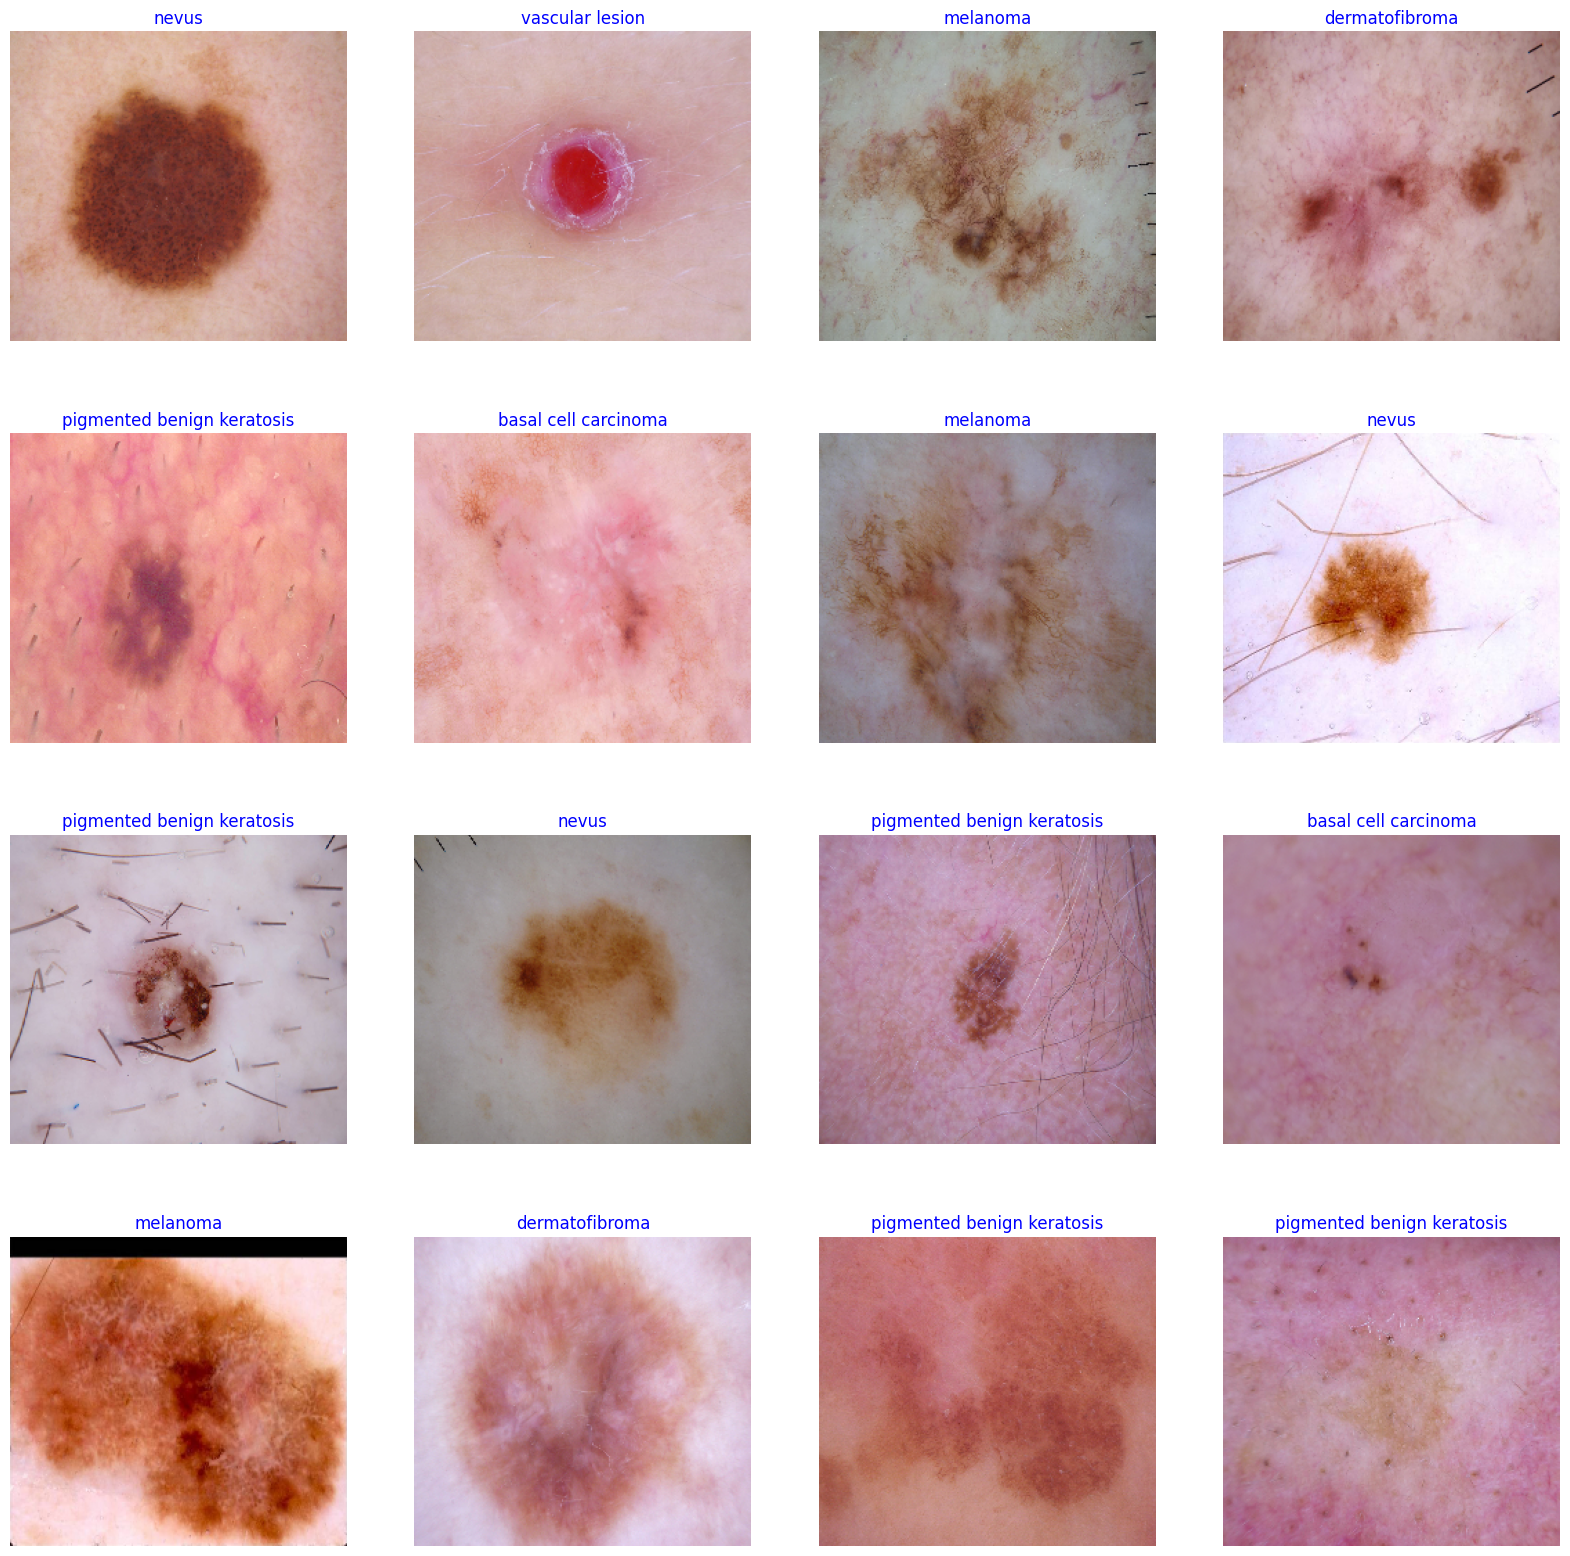

In [8]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

# Make CNN pre trained

In [9]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

258076736/258076736 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                       

In [10]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10


2024-12-07 07:51:11.782645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - 205s 677ms/step - loss: 9.8509 - accuracy: 0.3984 - val_loss: 8.7069 - val_accuracy: 0.5763
Epoch 2/10
140/140 [==============================] - 88s 628ms/step - loss: 7.5022 - accuracy: 0.6485 - val_loss: 7.4180 - val_accuracy: 0.4746
Epoch 3/10
140/140 [==============================] - 88s 628ms/step - loss: 6.0159 - accuracy: 0.7722 - val_loss: 6.1437 - val_accuracy: 0.5763
Epoch 4/10
140/140 [==============================] - 88s 628ms/step - loss: 4.8814 - accuracy: 0.8410 - val_loss: 5.2386 - val_accuracy: 0.5254
Epoch 5/10
140/140 [==============================] - 88s 628ms/step - loss: 3.9524 - accuracy: 0.8718 - val_loss: 4.5450 - val_accuracy: 0.5254
Epoch 6/10
140/140 [==============================] - 88s 628ms/step - loss: 3.1852 - accuracy: 0.8901 - val_loss: 3.7770 - val_accuracy: 0.5424
Epoch 7/10
140/140 [==============================] - 88s 628ms/step - loss: 2.5402 - accuracy: 0.8959 - val_loss: 3.1254 - val_accuracy: 0.

# Model1 performance

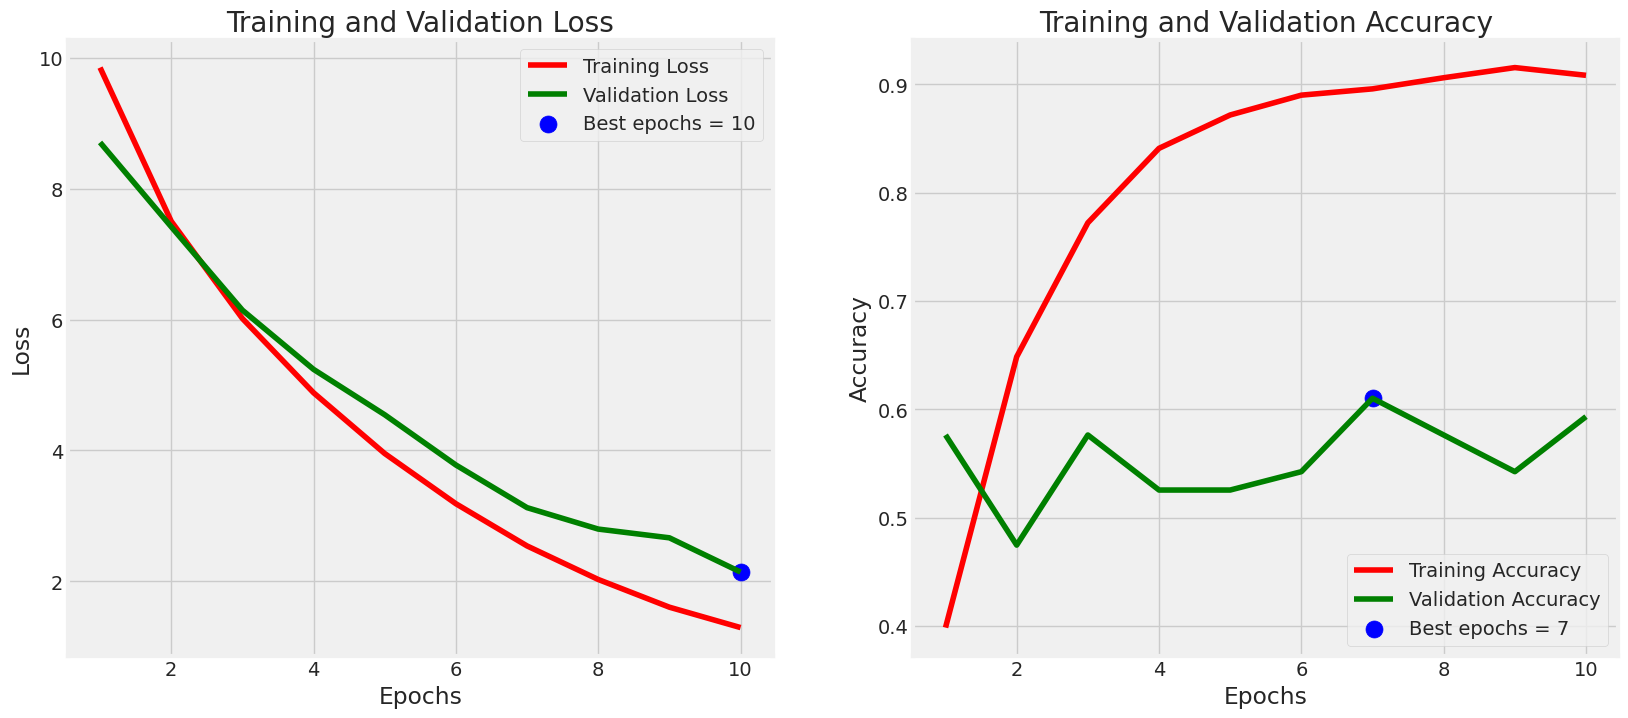

In [11]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# Model1 Evaluation

In [12]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 3s 134ms/step - loss: 2.5699 - accuracy: 0.4576
Train Loss:  1.0578676462173462
Train Accuracy:  0.9375
--------------------
Validation Loss:  2.1410317420959473
Validation Accuracy:  0.5932203531265259
--------------------
Test Loss:  2.5699048042297363
Test Accuracy:  0.4576271176338196


# Model Prediction
# Confusion Matrix and Classification Report

In [13]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

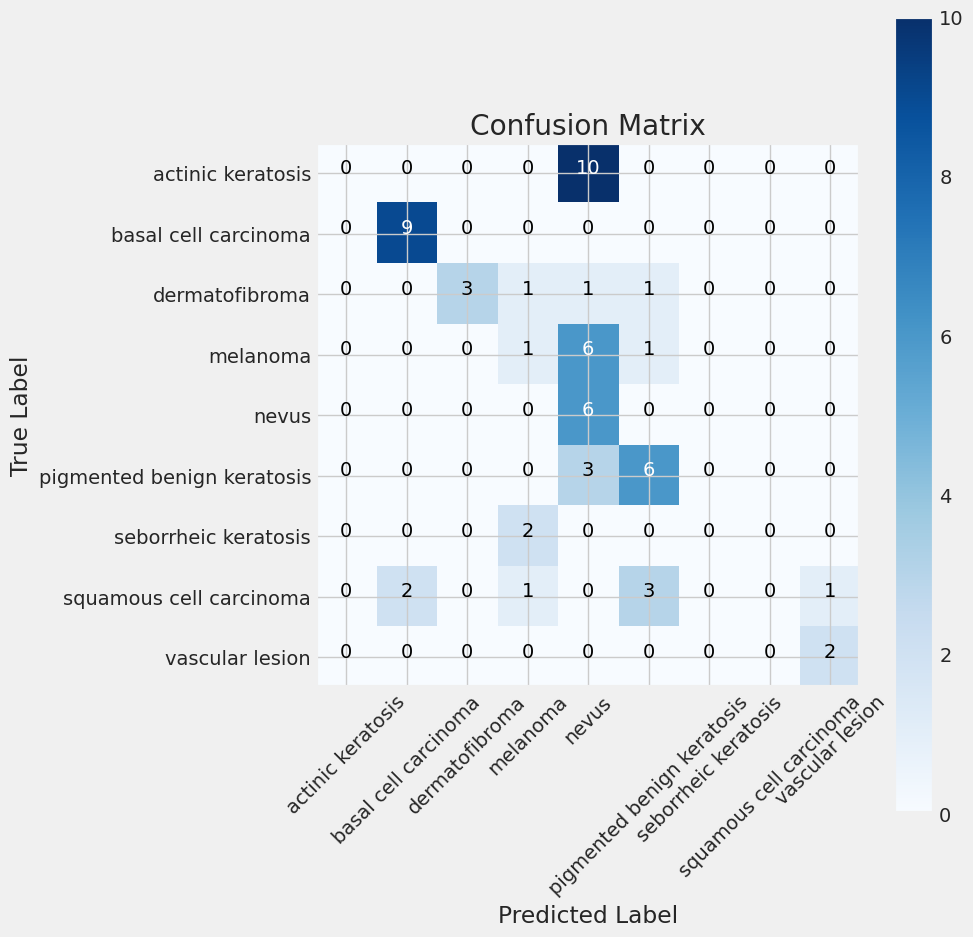

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        10
      basal cell carcinoma       0.82      1.00      0.90         9
            dermatofibroma       1.00      0.50      0.67         6
                  melanoma       0.20      0.12      0.15         8
                     nevus       0.23      1.00      0.38         6
pigmented benign keratosis       0.55      0.67      0.60         9
      seborrheic keratosis       0.00      0.00      0.00         2
   squamous cell carcinoma       0.00      0.00      0.00         7
           vascular lesion       0.67      1.00      0.80         2

                  accuracy                           0.46        59
                 macro avg       0.38      0.48      0.39        59
              weighted avg       0.38      0.46      0.38        59



In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image

# Define the URL of the image
image_url = 'https://pensacoladerm.com/wp-content/uploads/2018/12/Basal-Cell-Carcinoma.jpeg'

# Function to load and preprocess the image
def load_and_preprocess_image(img_url, img_size):
    # Fetch the image from the URL
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    
    # Resize the image to the required input size
    img = img.resize((img_size[1], img_size[0]))  # Note the order: width first, then height

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the model input shape (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

 # Normalize the image data to the range [0, 1]
    img_array /= 255.0
    
    return img_array

# Define the image size according to the expected input shape of the model
img_size = (224, 244)  # Height=224, Width=244

# Load and preprocess the image
preprocessed_image = load_and_preprocess_image(image_url, img_size)

# Make predictions using the model
predictions = model.predict(preprocessed_image)

# Get the predicted class (assuming you have a softmax output)
predicted_class = np.argmax(predictions, axis=1)

# Print results
print("Predicted class index:", predicted_class)
print("Predicted probabilities:", predictions)


1/1 [==============================] - 5s 5s/step
Predicted class index: [5]
Predicted probabilities: [[0.01048652 0.02697941 0.00580149 0.0402721  0.22269604 0.66134137
  0.00286187 0.00846446 0.02109671]]
